In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train = pd.read_parquet('/content/drive/My Drive/NLP/train.parquet')
test = pd.read_parquet('/content/drive/My Drive/NLP/test.parquet')

In [9]:
train.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [11]:
train['text'] = train['Title'] + ' ' + train['Body']
data = train.drop(['Tags', 'Title', 'Body'], axis=1)

In [12]:
data.head()

,target,text
Id,,
34862324,2,I am implementing a Minimum Spanning Forrest a...
47303682,2,"R Studio: Date is getting converted to number,..."
46431243,0,Pandas - dataframe groupby - how to get sum of...
45306324,0,Casting results from Observable.forkJoin to th...
49479547,1,Environment variable set in batch file cannot ...


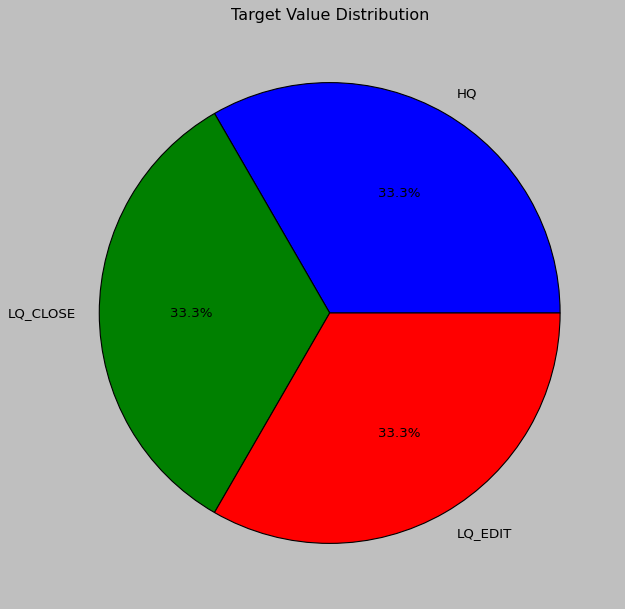

In [13]:
labels = ['HQ', 'LQ_CLOSE', 'LQ_EDIT']
values = [len(data[data['target'] == 0]), len(data[data['target'] == 1]), len(data[data['target'] == 2])]
plt.style.use('classic')
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Target Value Distribution")
plt.show()

Данные распределены равномерно по категориям текста.

Проведем очистку данных

In [27]:
def clean_text(dataframe, field='text'):
  def clean_str(text): 
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text
  dataframe[field] = dataframe[field].apply(clean_str)
  return dataframe

data = clean_text(data)

In [28]:
data.head()

,target,text
Id,,
34862324,2,i am implementing a minimum spanning forrest a...
47303682,2,r studio date is getting converted to number w...
46431243,0,pandas dataframe groupby how to get sum of m...
45306324,0,casting results from observableforkjoin to the...
49479547,1,environment variable set in batch file cannot ...


# Разделение данных на тренировочную и тестовую выборки

In [16]:
def split(data):
  split_pcent = 0.25
  split = int(split_pcent * len(data))

  data = data.sample(frac=1).reset_index(drop=True)

  train = data[split:]
  trainX = train['text']
  trainY = train['target'].values

  test = data[:split]
  testX = test['text']
  testY = test['target'].values

  print(f"Training Data Shape: {trainX.shape}\nTest Data Shape: {testX.shape}")
  return trainX, trainY, testX, testY

trainX, trainY, testX, testY = split(data)

Training Data Shape: (36000,)
Test Data Shape: (12000,)


In [17]:
[len(trainY[trainY == 0]), len(trainY[trainY == 1]), len(trainY[trainY == 2])]

[12012, 12050, 11938]

# Векторизация данных

## 1. BOW (Bag of words)

In [47]:
def bow(train, test):
  bow_vectorizer = CountVectorizer()
  train_vec = bow_vectorizer.fit_transform(train)
  test_vec = bow_vectorizer.transform(test)
  return train_vec, test_vec

## 2. tf-idf

In [62]:
def tf_idf(train, test):
  tfidf_vectorizer = TfidfVectorizer()
  train_vec = tfidf_vectorizer.fit_transform(train)
  test_vec = tfidf_vectorizer.transform(test)

  return train_vec, test_vec

# 3. W2V (word to vec)

In [88]:
from gensim.models import Word2Vec
import gensim
from multiprocessing import cpu_count
import numpy as np

def split_sentence_to_words(serias, field='text'):
  def split_str(text): 
    return text.split()
  serias = serias.apply(split_str)
  return serias

def get_own_w2v(data):
  words = split_sentence_to_words(data)
  return Word2Vec(words, min_count = 1, workers=cpu_count())

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        print(f"cannot compute similarity with no input {words}")
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

model = get_own_w2v(trainX)

# w2v_test_x = word_averaging_list(model,testX)


# model.build_vocab(data_part2, update=True)
# model.train(data_part2, total_examples=model.corpus_count, epochs=model.iter)

In [103]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        # if isinstance(word, np.ndarray) or word is list:
        mean.append(word)
        # elif word in wv.vocabulary:
            # mean.append(wv.syn0norm[wv.vocab[word].index])
            # all_words.add(wv.vocab[word].index)

    if not mean:
        print(f"cannot compute similarity with no input {words}")
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])


test_x = split_sentence_to_words(testX)
w2v_test_x = word_averaging_list(model, test_x)

TypeError: ignored

In [80]:
import gensim.downloader as api
word2vec_model300 = api.load('word2vec-google-news-300')
word2vec_model300['upload']

[=================================================-] 99.8% 1659.2/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([-0.08251953, -0.03393555, -0.05200195,  0.08691406,  0.04663086,
        0.10205078,  0.11523438,  0.14941406,  0.07617188, -0.02319336,
       -0.28515625,  0.06298828, -0.06591797,  0.08105469, -0.18261719,
        0.34765625,  0.25390625,  0.21386719, -0.03833008, -0.20800781,
       -0.01513672,  0.05859375, -0.31054688,  0.3125    , -0.046875  ,
       -0.21386719,  0.09960938, -0.140625  ,  0.13964844, -0.31445312,
       -0.25      , -0.00430298, -0.02282715, -0.15625   , -0.19921875,
       -0.33398438,  0.00476074, -0.20996094,  0.18164062,  0.16015625,
       -0.11425781,  0.23535156,  0.31445312,  0.15722656,  0.01086426,
       -0.2890625 , -0.08105469,  0.12988281,  0.0213623 , -0.0625    ,
       -0.17871094, -0.30859375,  0.26953125, -0.16308594, -0.00300598,
       -0.01782227, -0.05444336,  0.05200195, -0.20507812,  0.31445312,
        0.48828125, -0.16601562, -0.23828125, -0.16992188, -0.1484375 ,
        0.05541992, -0.19140625,  0.00189209,  0.26171875,  0.34

# Построение классификаторов


## 1. kNN

In [20]:
def knn_score(trainX, trainY, testX, testY):
  knn_classifier = KNeighborsClassifier()
  knn_classifier.fit(trainX, trainY)
  return knn_classifier.score(testX, testY)

## 2. Random Forests

In [21]:
def random_forest_score(trainX, trainY, testX, testY):
  rf_classifier = RandomForestClassifier()
  rf_classifier.fit(trainX, trainY)
  return rf_classifier.score(testX, testY)

## 3. Логистическая регрессия

In [22]:
def lr_score(trainX, trainY, testX, testY):
  lr_classifier = LogisticRegression()
  lr_classifier.fit(trainX, trainY)
  return lr_classifier.score(testX, testY)

In [ ]:
========================================================================================================================
========================================================================================================================
========================================================================================================================

In [52]:
data = data[:1000]

def visualize_results(score):
  print(score)

def base_pipeline(data, cleaner, spliter, vectorizer, scorer):
  cleared_text = cleaner(data)
  train_x, train_y, test_x, test_y = spliter(cleared_text)
  print(train_x.head())
  vectorized_train_x, vectorized_test_x = vectorizer(train_x, test_x)
  score = scorer(vectorized_train_x, train_y, vectorized_test_x, test_y)

  visualize_results(score)



# 1 attempt: basic cleaner, bow, knn 
base_pipeline(data, clean_text, split, tf_idf, random_forest_score)

Training Data Shape: (750,)
Test Data Shape: (250,)
250    how to make sublists comprised of unique value...
251    numbering each element of an arraylist in java...
252    how to cout with input in c phello guys actual...
253    why after i connection to sql server with libr...
254    how to use and operator between string values ...
Name: text, dtype: object
0.756
